# __ETL pipline project__

## Cities, Coutries and Population info

### Import necessary Python packages, modules and files

In [107]:
%pip install pymysql
%pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from lat_lon_parser import parse
from datetime import datetime # to get today's date
import pymysql as pymysql
import os
from dotenv import load_dotenv
load_dotenv()

True

### Assign impotant for access variables

In [3]:

local_schema = os.getenv("local_schema")
local_host = os.getenv("local_host")
local_password = os.getenv("local_password")

cloud_schema = os.getenv("cloud_schema")
cloud_host = os.getenv("cloud_host")
cloud_pasword = os.getenv("cloud_password")

port = os.getenv("port")
user = os.getenv("user")

api_key = os.getenv("API_KEY_OPENWEATHERMAP")
api_air = os.getenv("API_KEY_AERODATABOX")
api_air_ = os.getenv("API_KEY_AERODATABOX_")
api_key_ninja = os.getenv("API_KEY_API_Ninja")

### Find information about cities, scrape this info, transform and put it into the base

At this phase, I try to understand how we will scour the internet for information and then how we will transform these pieces into readable and understandable info which we can use in our database.

As we are interested in name, geo location, country and population for each city in our list of interests.

For these reasons, I will use BeautifulSoup and possibly any site which contains info about cities, countries, population and geo positions of these cities as an example — Wikipedia.

In [110]:
cities_list = ["Berlin", "Hamburg", "Cologne"]

def take_cities_info_bus(condition):
  """ To scrape (BeautifulSoup)info about list of cities ([...]) from WIKI.\n
      Put cities that you are interested in into a list 
  """
  df_dict = {
      "Cities": condition,
      "Country": [],
      "Latitude": [],
      "Longitude": [],
      "Population": [],
      "Population_date": []}

  for element in condition:
    cities_url =  f"https://en.wikipedia.org/wiki/{element}"
    headers = {"User-Agent": "Crome/139.0.0.0"}
    response = requests.get(cities_url, headers=headers)
    borsch = BeautifulSoup(response.content, 'html.parser')

    df_dict["Latitude"].append(parse(borsch.find(class_ = "latitude").get_text()))
    df_dict["Longitude"].append(parse(borsch.find(class_ = "longitude").get_text()))
    df_dict["Country"].append(borsch.find(class_ = "infobox-data" ).get_text())
    df_dict["Population"].append(borsch.find(string="Population").find_next("td").get_text())
    df_dict["Population_date"].append(datetime.today().strftime("%d.%m.%Y"))

  return pd.DataFrame(df_dict)

In [111]:
cities_df = take_cities_info_bus(cities_list)
cities_df

,Cities,Country,Latitude,Longitude,Population,Population_date
0,Berlin,Germany,52.520000,13.405000,"3,596,999",21.09.2025
1,Hamburg,Germany,53.550000,10.000000,"1,964,021",21.09.2025
2,Cologne,Germany,50.936389,6.952778,"1,024,408",21.09.2025


If we add to cities list Luxembourg, or Vinnytsia we will receive a little weird table (city name == country nameas an expl) with the simple data.

Can I put these pieces into the database? The obvious answer — No.

Can I solve these problems (right the rules for these two cases)? — Yes, but how many cases can we meet?

Let us look for free API sources to clarify information, and maybe our data frame will be more comprehensive and readable (at least for Luxembourg).

What about https://api-ninjas.com/api/city[API Ninjas]?

The procedure is almost the same except for a few moments: we do not have to parse a giant HTML file to find pieces of information; parsing a JSON is much easier. Because of this, I just put this piece of code, which solves all of these problems.

In [112]:
def take_cities_info_api(condition):
    """ To take info about list of cities ([...]) from API-Ninja.\n
        Put cities that you are interested in into a list 
    """
    cities_geo_list = []

    for name in cities_list:
            url = f'https://api.api-ninjas.com/v1/city?name={name}'
            cities_request = requests.get(url, headers={'X-Api-Key': api_key_ninja})
            cities_json = cities_request.json()
            cities_geo_list.append(cities_json)

    df_dict = {
        "city_name": cities_list,
        "country_code": [],
        "latitude": [],
        "longitude": [],
        "population": [],
        "pop_date": []}

    for position in (cities_geo_list):
        df_dict["country_code"].append(position[0]["country"])
        df_dict["latitude"].append(position[0]["latitude"])
        df_dict["longitude"].append(position[0]["longitude"])
        df_dict["population"].append(position[0]["population"])
        df_dict["pop_date"].append(datetime.today())

    return pd.DataFrame(df_dict)

In [113]:
alternative_cities_df = take_cities_info_api(cities_list)
alternative_cities_df

,city_name,country_code,latitude,longitude,population,pop_date
0,Berlin,DE,52.5167,13.3833,3644826,2025-09-21 14:39:13.396756
1,Hamburg,DE,53.5500,10.0000,1841179,2025-09-21 14:39:13.396756
2,Cologne,DE,50.9422,6.9578,1085664,2025-09-21 14:39:13.396756


The obvious advantage is that we have structured information and can read and use it through a loop, without magic or reading HTML code.
* __Conclusion: Use the API when you have it, not parsing!__


### Add received table into SQL Database
Our next step - put this beautiful (without unnecessary modesty) table into the database. Behind the scenes, I have prepared the database.

In [ ]:
CREATE DATABASE cities_info;

USE cities_info;

CREATE TABLE countries (
country_id INT AUTO_INCREMENT,
country_code VARCHAR(255) NOT NULL,
PRIMARY KEY (country_id)
);

CREATE TABLE cities (
city_id INT AUTO_INCREMENT,
city_name VARCHAR(255) NOT NULL,
latitude FLOAT(8) NOT NULL,
longitude FLOAT(8) NOT NULL,
country_id INT,
PRIMARY KEY (city_id),
FOREIGN KEY(country_id) REFERENCES countries(country_id)
);

CREATE TABLE population_info(
pop_id INT AUTO_INCREMENT,
population INT NOT NULL,
pop_date DATETIME NOT NULL,
city_id INT,
PRIMARY KEY (pop_id), 
FOREIGN KEY (city_id) REFERENCES cities (city_id)
);

CREATE TABLE weather(
weather_id INT AUTO_INCREMENT,
date_stmp DATETIME,
temp float8,
temp_min float8,
temp_max float8,
wind_speed float8,
wind_gust float8,
visibility	INT,
weather_marker	VARCHAR(256),
precipitation FLOAT(8),
last_call DATETIME,
city_id INT,
PRIMARY KEY (weather_id), 
FOREIGN KEY (city_id) REFERENCES cities (city_id)
);

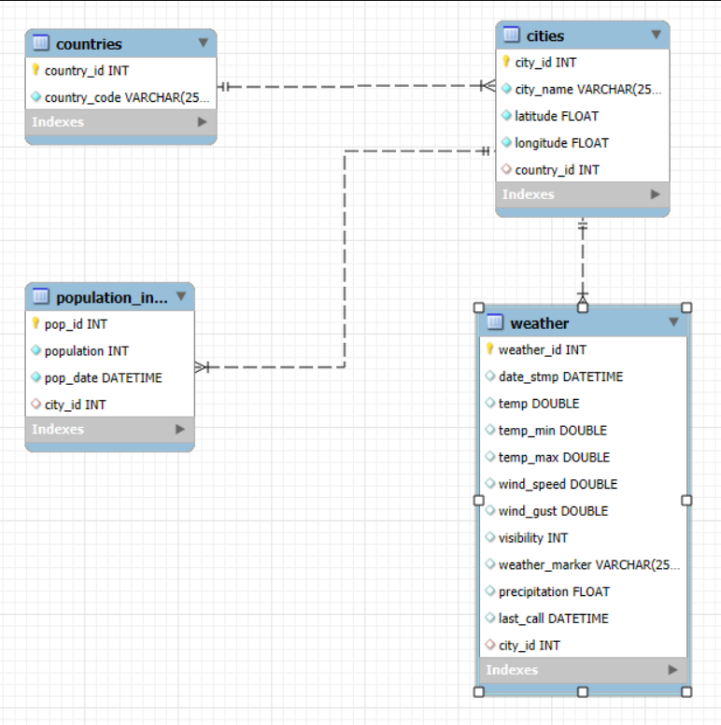


My next step — to prepare all necessary functions to connect and work with the SQL database and put all tables into DB…

In [114]:
# to create connection string
def create_connection_string(schema, user, password, host, port):
    return f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

# to move the table into the db
def df_to_sql(df, table_name, connection_string):
    df.to_sql(
        table_name,
        if_exists="append",
        con=connection_string,
        index=False)
    print(f"{table_name} Successfully added!")

#to read table from SQL
def read_table_sql(table_name, connection_string):
    table = pd.read_sql(
    table_name,
    con=connection_string)
    return table

Then create a connection string

In [117]:
connection_string = create_connection_string(local_schema, user, local_password, local_host, port)

We are ready to fill our the firdt table:

In [15]:
countries = pd.DataFrame({"country_code":alternative_cities_df.country_code.unique()}) 
df_to_sql(countries, "countries",connection_string)

Successfully added!


Next, we would like to take country keys from our new SQL table and add them into our cities table to create connection inside database. To solve this problem we will read countries table from SQL and than merge our "alternative_cities_df" and SQL table.

Than will we drop a column "country_code" because we already have this info in our base.

In [16]:
countries_SQL_table = read_table_sql("countries", connection_string)
alternative_cities_df = alternative_cities_df.merge(
    countries_SQL_table,
    on="country_code",
    how="left"
).drop("country_code", axis=1)


Let`s create "cities", and read this table to receive cities id from SQL

In [ ]:
cities_SQL = alternative_cities_df.drop(columns=["population","pop_date"])
df_to_sql(cities_SQL, "cities",connection_string)
cities_SQL = read_table_sql("cities",connection_string)

New step and new table. This time - "population_info"

In [ ]:
population_df = alternative_cities_df.merge(
    cities_SQL,
    on="city_name",
    how="left"
)[["city_id", "population", "pop_date"]]
population_df

In [ ]:
df_to_sql(population_df, "population_info", connection_string)

### Combine everything together

In [ ]:
cities_list = ["Berlin", "Hamburg", "Cologne"]


def preparation_loading_to_sql(cities_list):

    local_schema = os.getenv("local_schema")
    local_host = os.getenv("local_host")
    local_password = os.getenv("local_password")

    port = os.getenv("port")
    user = os.getenv("user")    
    

    cities_df = take_cities_info_api(cities_list)
    create_connection_string(local_schema, user, local_password, local_host, port)
    countries = pd.DataFrame({"country_code":cities_df.country_code.unique()}) 
    df_to_sql(countries, "countries",connection_string)
    countries_SQL_table = read_table_sql("countries", connection_string)

    cities_df = cities_df.merge(
        countries_SQL_table,
        on="country_code",
        how="left"
    ).drop("country_code", axis=1)

    cities_SQL = cities_df.drop(columns=["population","pop_date"])
    df_to_sql(cities_SQL, "cities",connection_string)
    cities_SQL = read_table_sql("cities",connection_string)
    
    population_df = cities_df.merge(
        cities_SQL,
        on="city_name",
        how="left"
    )[["city_id", "population", "pop_date"]]
    df_to_sql(population_df, "population_info", connection_string)



In [23]:
preparation_loading_to_sql(cities_list)

Successfully added!
Successfully added!
Successfully added!
Successfully added!


## Weather information 

We collect all necessary information about cities that we are interested in, and the next step — to collect, clean and send into our database all information about the weather and weather forecasts. First of all, we should ask for geo information from our local DB and pass it into the function:

In [ ]:
cities_SQL = read_table_sql("cities",connection_string)
cities_SQL

And now we are ready to prepare our first function for fetch raw weather data from API server:

In [ ]:
def get_weather_info(df):
    weather = []
    
    for i in range (df.shape[0]):
        url = f"https://api.openweathermap.org/data/2.5/forecast?lat={df.iloc[i][2]}&lon={df.iloc[i][3]}&units=metric&lang=en&appid={api_key}"
        weather_request = requests.get(url)
        weather_json = weather_request.json()
        weather.append(weather_json)
    return weather

What does it mean — we pass into this function our cities_sql table, and inside this function, with a loop will ask every row (df.iloc[i]) for lat (df.iloc[i][2]) and lon (df.iloc[i][2]) info. This function helps us to collect all necessary raw weather data, and then we should clear this mess and take only the important data for our cells.

In [ ]:
def clean_weather_info(df):
    weather = get_weather_info(df)
    weather_dict = {
        "city_id":[],
        "date_stmp": [],
        "temp":[],
        "temp_min":[],
        "temp_max":[],
        "wind_speed":[],
        "wind_gust":[],
        "visibility":[],
        "weather_marker":[],
        "precipitation":[],
        "last_call":[],
        "lat":[],
        "lon":[]}

    for i in range(len(weather)):
        for j in range(len(weather[i])):
            weather_dict["city_id"].append(df.iloc[i][0])
            weather_dict["lat"].append(weather[i]["city"]["coord"]["lat"])
            weather_dict["lon"].append(weather[i]["city"]["coord"]["lon"])
            weather_dict["date_stmp"].append(datetime.fromtimestamp(weather[i]["list"][j]["dt"]))
            weather_dict["temp"].append(weather[i]["list"][j]["main"]["temp"])
            weather_dict["temp_min"].append(weather[i]["list"][j]["main"]["temp_min"])
            weather_dict["temp_max"].append(weather[i]["list"][j]["main"]["temp_max"])
            weather_dict["wind_speed"].append(weather[i]["list"][j]["wind"]["speed"])
            weather_dict["wind_gust"].append(weather[i]["list"][j]["wind"]["gust"])
            weather_dict["visibility"].append(weather[i]["list"][j]["visibility"])
            weather_dict["weather_marker"].append(weather[i]["list"][j]["weather"][0]["main"])
            weather_dict["precipitation"].append(weather[i]["list"][j]["pop"])
            weather_dict["last_call"].append(datetime.today())

    weather_df = pd.DataFrame(weather_dict).drop(columns=["lat","lon"])
    return (weather_df)

### Combine everything together

In [ ]:
def prepare_and_save_weather():
    connection_string = create_connection_string(local_schema, user, local_password, local_host, port)
    cities_df = read_table_sql("cities",connection_string)
    weather_df = clean_weather_info(cities_df)
    df_to_sql(weather_df, "weather", connection_string)

## Airports and flight info

Before we start downloading all airports and flight info into our database, we should prepare the space in it for our new tables.

So, as we understand, the cities’ info is constantly information as airport info also, we know that our cities can grow, can disappear like during the Russian invasion in Ukraine (and the airports also), but in the world of our dreams, we understand that this info will be constant. That means we should build a separate table for airports (if the cities of our interests open one more) and one bridge table between airports and cities table, for cases when one airport belongs to two cities or one city has two airports.

And one table for flight information, which will connect with the airports table through the key.


In [ ]:
CREATE TABLE airports(
icao VARCHAR(256),
iata VARCHAR(256),
airport_name VARCHAR(256),
shortName VARCHAR(256),
municipalityName VARCHAR(256),
timeZone VARCHAR(256),
latitude FLOAT(8),
longitude FLOAT(8), 
PRIMARY KEY (iata)
);

CREATE TABLE cities_airports(
airport_city_id INT AUTO_INCREMENT,
iata VARCHAR(256),
icao VARCHAR(256),
city_id INT,
PRIMARY KEY (airport_city_id), 
FOREIGN KEY (city_id) REFERENCES cities (city_id),
FOREIGN KEY (iata) REFERENCES airports (iata)
);

CREATE TABLE flights(
	flight_id INT AUTO_INCREMENT,
	iata VARCHAR(256),
	airport_departure VARCHAR(256),
	airport_departure_iata_code VARCHAR(256),
    arrival_schedule DATETIME,
    flight_number VARCHAR(256),	
    flight_status VARCHAR(256),
    airplane VARCHAR(256),
	airline_name VARCHAR(256), 
    fetch_date DATETIME,
    PRIMARY KEY (flight_id),
    FOREIGN KEY (iata) REFERENCES airports (iata)
);

At the moment, our schema looks like this:

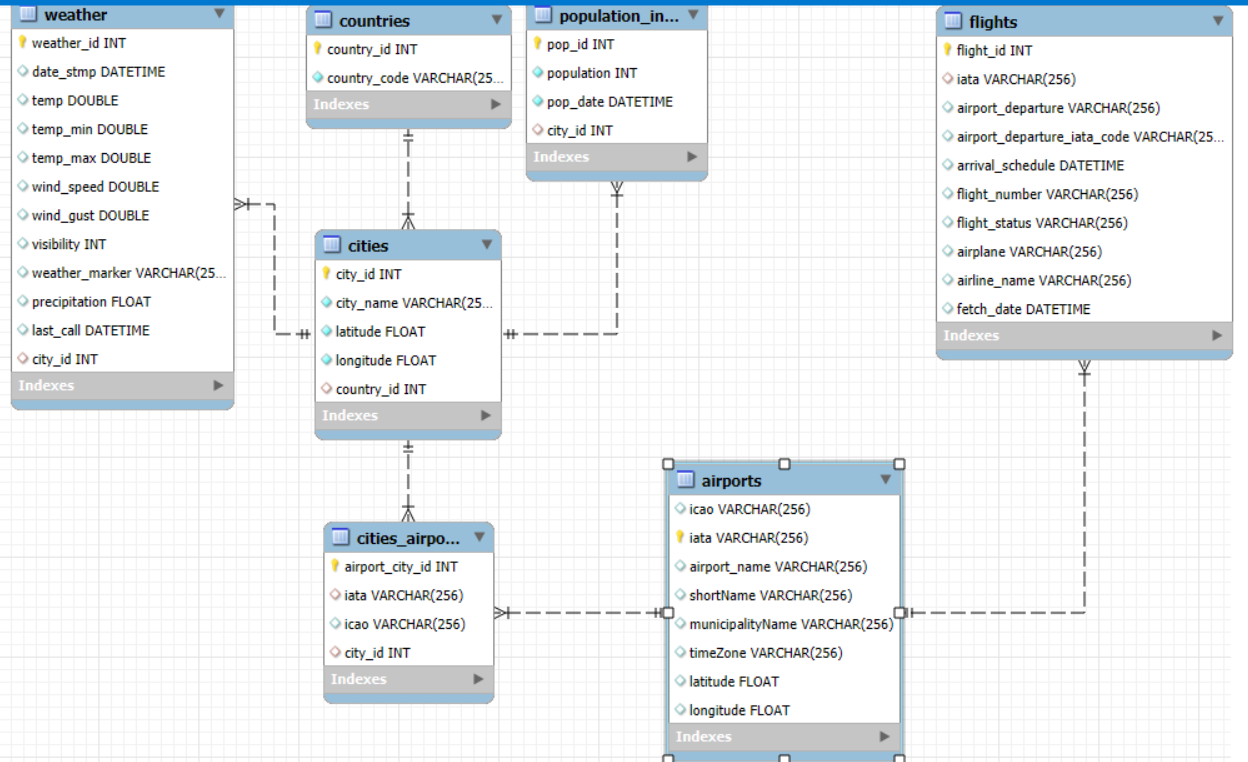

Let us drive into the airports and flights API

### Airports info

Import necessary libraries

In [ ]:
import datetime
import time
from pytz import timezone
from datetime import datetime, timedelta

Take info from our local base to received cities geo info

In [ ]:
def fetch_cities_info(connection_string):
    cities_df = read_table_sql("cities",connection_string)
    latitude_list = list(cities_df.latitude)
    longitude_list = list(cities_df.longitude)
    return latitude_list, longitude_list

cities_loc_sql_info = fetch_cities_info(connection_string)

Iterate trough this lisys to receievd info about aerports nearby

In [ ]:
def check_airports(cities_loc_sql_info):

    url = "https://aerodatabox.p.rapidapi.com/airports/search/location"
    headers = {
            "x-rapidapi-key": api_air_,
            "x-rapidapi-host": "aerodatabox.p.rapidapi.com"
        }
    
    airport_list =[]

    for lat, lon in zip(cities_loc_sql_info[0], cities_loc_sql_info[1]):
        querystring = {"lat":lat,"lon":lon,"radiusKm":"22","limit":"10","withFlightInfoOnly":"false"}
        response = requests.get(url, headers=headers, params=querystring)
        city_airports = pd.json_normalize(response.json().get('items', []))
        airport_list.append(city_airports)
    return pd.concat(airport_list,ignore_index=True)


airports_df = check_airports(cities_loc_sql_info)

Prepare this information to put these tables into our local base

In [ ]:
def prepare_airports_info(airports_df):
    airports_df = airports_df.drop("countryCode", axis=1)
    airports_df = cities_SQL.merge(
        airports_df,
        left_on="city_name",
        right_on="municipalityName",
        how="left"
    ).drop(columns=["city_name", "latitude", "longitude", "country_id"])
    airports_df = airports_df.rename(columns={"name": "airport_name", "location.lat":"latitude","location.lon":"longitude"})
    airports_df = airports_df[["icao","iata","airport_name","shortName","municipalityName","latitude","longitude", "city_id"]]
    city_airport_table = airports_df.drop(columns=["airport_name","shortName","municipalityName","latitude","longitude"])
    df_to_sql(city_airport_table, "cities_airports", connection_string)
    airports_table = airports_df.drop("city_id", axis=1)
    df_to_sql(airports_table, "airports", connection_string)
    
prepare_airports_info(airports_df)    

### Flights

Finally, we can fetch flight information and also add it to our local base. As a first step, take info from the base through API, and then we should magic up this mess into a readable table to put into the database.

Press enter or click to view image in full size


In [ ]:
def flights_info(airports_df):
    berlin_timezone = timezone('Europe/Berlin')
    today = datetime.now(berlin_timezone).date()
    tomorrow = (today + timedelta(days=1))

    schedule_dict = {
      "airports": [],
      "raw_data":[],
      "fetch_date":[]
      }

    headers = {
      "x-rapidapi-key": api_air_,
      "x-rapidapi-host": "aerodatabox.p.rapidapi.com"
    }   
    
    for i in range(airports_df.shape[0]):
        times = [["00:00","11:59"],["12:00","23:59"]]
        for time in times:
          url = f"https://aerodatabox.p.rapidapi.com/flights/airports/iata/{airports_df.iloc[i][1]}/{tomorrow}T{time[0]}/{tomorrow}T{time[1]}"
          querystring = {"withLeg":"true",
                         "direction":"Arrival",
                         "withCancelled":"false",
                         "withCodeshared":"false",
                         "withCargo":"false",
                         "withPrivate":"false"}
          response = requests.get(url, headers=headers, params=querystring)
          if response.status_code == 200:
            data = response.json()
          #   airports = pd.json_normalize(data.get('items', []))
            schedule_dict["airports"].append(airports_df.iloc[i][1])
            schedule_dict["fetch_date"].append(datetime.now(berlin_timezone).strftime("%Y-%m-%d %H:%M:%S"))
            schedule_dict["raw_data"].append(data)
          else: print(airports_df.iloc[i][1],": ",response.status_code)
    return schedule_dict

flights = flights_info(airports_df)

Ok, now we should magic up this mess into readable table to put in into the database:

In [ ]:
def flights_df_construct(flights):
    schedule_dict = {
        "iata": [],
        "airport_departure":[],
        "airport_departure_iata_code":[],
        "arrival_schedule":[],
        # "arrival_received":[],
        "flight_number" :[],
        "flight_status":[],
        "airplane" :[],
        "airline_name":[],
        "fetch_date":[]
    }

    for i in range(len(flights["airports"])):
        for j in flights["raw_data"]:
            for flight in j['arrivals']:
                schedule_dict["iata"].append(flights["airports"][i])
                schedule_dict["airport_departure"].append(flight["departure"]['airport']["name"])
                schedule_dict["airport_departure_iata_code"].append(flight["departure"]['airport'].get("iata", None))
                schedule_dict["arrival_schedule"].append(flight["arrival"]["scheduledTime"].get("local", None).split("+")[0])
                # print(flight["arrival"]["revisedTime"].get("local", None))
                # schedule_dict["arrival_received"].append(flight["arrival"]["revisedTime"]["local"] )
                schedule_dict["flight_number"].append(flight["number"] )
                schedule_dict["flight_status"].append(flight["status"] )
                if flight.get("aircraft") != None:
                    schedule_dict["airplane"].append(flight["aircraft"].get("model", None))
                else: schedule_dict["airplane"].append("None")
                schedule_dict["airline_name"].append(flight["airline"]["name"])
                schedule_dict["fetch_date"].append(min(flights["fetch_date"]))
        
    
    return pd.DataFrame(schedule_dict)

And finaly put it...

In [ ]:
def add_flights_schedule(schedule_df):
    df_to_sql(schedule_df, flights, connection_string)

# One big function

Once we have all the necessary information, we can create a cloud database that will run on schedule. At this stage, we need to:

• Create the cloud database

• Build one function which will load basement information from the local machine (from the notebook) to the cloud base.

• Build a second function which will work in the cloud and take the necessary information from a scheduler

• Set up the schedule

### Build one function which will load basement information from the local machine (from the notebook) to the cloud base.

In [4]:
# to create connection string
def create_connection_string(schema, user, password, host, port):
    return f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

# to move the table into the db
def df_to_sql(df, table_name, connection_string):
    df.to_sql(
        table_name,
        if_exists="append",
        con=connection_string,
        index=False)
    print(f"{table_name} Successfully added!")

#to read table from SQL
def read_table_sql(table_name, connection_string):
    table = pd.read_sql(
    table_name,
    con=connection_string)
    return table

In [5]:
def take_cities_info_api(condition):
    """ To take info about list of cities ([...]) from API-Ninja.\n
        Put cities that you are interested in into a list 
    """
    cities_geo_list = []

    for name in cities_list:
            url = f'https://api.api-ninjas.com/v1/city?name={name}'
            cities_request = requests.get(url, headers={'X-Api-Key': api_key_ninja})
            cities_json = cities_request.json()
            cities_geo_list.append(cities_json)

    df_dict = {
        "city_name": cities_list,
        "country_code": [],
        "latitude": [],
        "longitude": [],
        "population": [],
        "pop_date": []}

    for position in (cities_geo_list):
        df_dict["country_code"].append(position[0]["country"])
        df_dict["latitude"].append(position[0]["latitude"])
        df_dict["longitude"].append(position[0]["longitude"])
        df_dict["population"].append(position[0]["population"])
        df_dict["pop_date"].append(datetime.today())

    return pd.DataFrame(df_dict)

In [6]:
def fetch_cities_airports_info(cities_df):
    
    latitude_list = list(cities_df.latitude)
    longitude_list = list(cities_df.longitude)
    
    url = "https://aerodatabox.p.rapidapi.com/airports/search/location"
    headers = {
            "x-rapidapi-key": api_air_,
            "x-rapidapi-host": "aerodatabox.p.rapidapi.com"
        }
    
    airport_list =[]

    for lat, lon in zip(latitude_list, longitude_list):
        querystring = {"lat":lat,"lon":lon,"radiusKm":"22","limit":"10","withFlightInfoOnly":"false"}
        response = requests.get(url, headers=headers, params=querystring)
        city_airports = pd.json_normalize(response.json().get('items', []))
        airport_list.append(city_airports)
    return pd.concat(airport_list,ignore_index=True)

In [ ]:
def prepare_airports_info(airports_df):

    connection_string = create_connection_string(cloud_schema, user, cloud_pasword, cloud_host, port)
    
    airports_df = airports_df.drop("countryCode", axis=1)
    cities_SQL = read_table_sql("cities",connection_string)

    airports_df = cities_SQL.merge(
        airports_df,
        left_on="city_name",
        right_on="municipalityName",
        how="left"
    ).drop(columns=["city_name", "latitude", "longitude", "country_id"])

    airports_df = airports_df.rename(columns={"name": "airport_name", "location.lat":"latitude","location.lon":"longitude"})
    airports_df = airports_df[["icao","iata","airport_name","shortName","municipalityName","latitude","longitude", "city_id"]]

    airports_table = airports_df.drop("city_id", axis=1)
    city_airport_table = airports_df.drop(columns=["airport_name","shortName","municipalityName","latitude","longitude"])
    
    df_to_sql(airports_table, "airports", connection_string)
    df_to_sql(city_airport_table, "cities_airports", connection_string)
    

In [ ]:
cities_list = ["Berlin", "Hamburg", "Cologne"]


def retrieve_send_cities_airports_data(cities_list):
    """ Takes two lists with geo coordinates and returns the data frame with airport, codes of airports and their geo coordinates"""

    cities_df = take_cities_info_api(cities_list)
    connection_string = create_connection_string(cloud_schema, user, cloud_pasword, cloud_host, port)
    
    ## COUNTRIES TABLE
    countries = pd.DataFrame({"country_code":cities_df.country_code.unique()}) 
    df_to_sql(countries, "countries",connection_string)
    countries_SQL_table = read_table_sql("countries", connection_string)

    ## CITIES TABLE
    cities_df = cities_df.merge(
        countries_SQL_table,
        on="country_code",
        how="left"
    ).drop("country_code", axis=1)

    cities_SQL = cities_df.drop(columns=["population","pop_date"])
    df_to_sql(cities_SQL, "cities",connection_string)
    cities_SQL = read_table_sql("cities",connection_string)
    
    ## POPULATION TABLE
    population_df = cities_df.merge(
        cities_SQL,
        on="city_name",
        how="left"
    )[["city_id", "population", "pop_date"]]
    df_to_sql(population_df, "population_info", connection_string)

    airports_df = fetch_cities_airports_info(cities_SQL)
    prepare_airports_info(airports_df)   

In [11]:
retrieve_send_cities_airports_data(cities_list)


countries Successfully added!
cities Successfully added!
population_info Successfully added!
airports Successfully added!
cities_airports Successfully added!


### Build a second function which will work in the cloud and take the necessary information from a scheduler

In [13]:
def get_weather_info(df):
    weather = []
    
    for i in range (df.shape[0]):
        url = f"https://api.openweathermap.org/data/2.5/forecast?lat={df.iloc[i][2]}&lon={df.iloc[i][3]}&units=metric&lang=en&appid={api_key}"
        weather_request = requests.get(url)
        weather_json = weather_request.json()
        weather.append(weather_json)
    return weather

In [43]:
def clean_weather_info(df):
    weather = get_weather_info(df)
    weather_dict = {
        "city_id":[],
        "date_stmp": [],
        "temp":[],
        "temp_min":[],
        "temp_max":[],
        "wind_speed":[],
        "wind_gust":[],
        "visibility":[],
        "weather_marker":[],
        "precipitation":[],
        "last_call":[],
        "lat":[],
        "lon":[]}

    for i in range(len(weather)):
        for j in range(len(weather[i])):
            weather_dict["city_id"].append(df.iloc[i][0])
            weather_dict["lat"].append(weather[i]["city"]["coord"]["lat"])
            weather_dict["lon"].append(weather[i]["city"]["coord"]["lon"])
            weather_dict["date_stmp"].append(datetime.fromtimestamp(weather[i]["list"][j]["dt"]))
            weather_dict["temp"].append(weather[i]["list"][j]["main"]["temp"])
            weather_dict["temp_min"].append(weather[i]["list"][j]["main"]["temp_min"])
            weather_dict["temp_max"].append(weather[i]["list"][j]["main"]["temp_max"])
            weather_dict["wind_speed"].append(weather[i]["list"][j]["wind"]["speed"])
            weather_dict["wind_gust"].append(weather[i]["list"][j]["wind"]["gust"])
            weather_dict["visibility"].append(weather[i]["list"][j]["visibility"])
            weather_dict["weather_marker"].append(weather[i]["list"][j]["weather"][0]["main"])
            weather_dict["precipitation"].append(weather[i]["list"][j]["pop"])
            weather_dict["last_call"].append(datetime.today())

    weather_df = pd.DataFrame(weather_dict).drop(columns=["lat","lon"])
    return (weather_df)

In [14]:
def retrieve_send_weather_data():

    connection_string = create_connection_string(cloud_schema, user, cloud_password, cloud_host, port)
    cities_df = read_table_sql("cities",connection_string)
    weather_df = clean_weather_info(cities_df)
    df_to_sql(weather_df, "weather", connection_string)

In [ ]:
retrieve_send_weather_data()

C:\Users\Andri\AppData\Local\Temp\ipykernel_5424\1914938261.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = f"https://api.openweathermap.org/data/2.5/forecast?lat={df.iloc[i][2]}&lon={df.iloc[i][3]}&units=metric&lang=en&appid={api_key}"
C:\Users\Andri\AppData\Local\Temp\ipykernel_5424\2049101634.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weather_dict["city_id"].append(df.iloc[i][0])


weather Successfully added!


In [ ]:
def flights_info(connection_string):
    
    import datetime
    import time
    from pytz import timezone
    from datetime import datetime, timedelta
    
    berlin_timezone = timezone('Europe/Berlin')
    today = datetime.now(berlin_timezone).date()
    tomorrow = (today + timedelta(days=1))

    schedule_dict = {
      "airports": [],
      "raw_data":[],
      "fetch_date":[]
      }

    headers = {
      "x-rapidapi-key": api_air_,
      "x-rapidapi-host": "aerodatabox.p.rapidapi.com"
    }   

    airports_df = read_table_sql("airports",connection_string)
    
    for i in range(airports_df.shape[0]):
        times = [["00:00","11:59"],["12:00","23:59"]]
        for time in times:
          url = f"https://aerodatabox.p.rapidapi.com/flights/airports/iata/{airports_df.iloc[i][1]}/{tomorrow}T{time[0]}/{tomorrow}T{time[1]}"
          querystring = {"withLeg":"true",
                         "direction":"Arrival",
                         "withCancelled":"false",
                         "withCodeshared":"false",
                         "withCargo":"false",
                         "withPrivate":"false"}
          response = requests.get(url, headers=headers, params=querystring)
          if response.status_code == 200:
            data = response.json()
            schedule_dict["airports"].append(airports_df.iloc[i][1])
            schedule_dict["fetch_date"].append(datetime.now(berlin_timezone).strftime("%Y-%m-%d %H:%M:%S"))
            schedule_dict["raw_data"].append(data)
          else: print(airports_df.iloc[i][1],": ",response.status_code)
    return schedule_dict


In [ ]:
def flights_df_construct(flights):
    schedule_dict = {
        "iata": [],
        "airport_departure":[],
        "airport_departure_iata_code":[],
        "arrival_schedule":[],
        # "arrival_received":[],
        "flight_number" :[],
        "flight_status":[],
        "airplane" :[],
        "airline_name":[],
        "fetch_date":[]
    }

    for i in range(len(flights["airports"])):
        for j in flights["raw_data"]:
            for flight in j['arrivals']:
                schedule_dict["iata"].append(flights["airports"][i])
                schedule_dict["airport_departure"].append(flight["departure"]['airport']["name"])
                schedule_dict["airport_departure_iata_code"].append(flight["departure"]['airport'].get("iata", None))
                schedule_dict["arrival_schedule"].append(flight["arrival"]["scheduledTime"].get("local", None).split("+")[0])
                # print(flight["arrival"]["revisedTime"].get("local", None))
                # schedule_dict["arrival_received"].append(flight["arrival"]["revisedTime"]["local"] )
                schedule_dict["flight_number"].append(flight["number"] )
                schedule_dict["flight_status"].append(flight["status"] )
                if flight.get("aircraft") != None:
                    schedule_dict["airplane"].append(flight["aircraft"].get("model", None))
                else: schedule_dict["airplane"].append("None")
                schedule_dict["airline_name"].append(flight["airline"]["name"])
                schedule_dict["fetch_date"].append(min(flights["fetch_date"]))
        
    
    return pd.DataFrame(schedule_dict)

In [ ]:
def retrieve_send_airports_flights_data():

    connection_string = create_connection_string(cloud_schema, user, cloud_pasword, cloud_host, port)

    raw_schedule = flights_info(connection_string)
    flights_df = flights_df_construct(raw_schedule)
    df_to_sql(flights_df, "flights", connection_string)

In [96]:
retrieve_send_airports_flights_data()

   icao iata                   name      shortName municipalityName  \
0  EDDT  TXL          Berlin -Tegel         -Tegel           Berlin   
1  EDDB  BER     Berlin Brandenburg    Brandenburg           Berlin   
2  EDDH  HAM                Hamburg        Hamburg          Hamburg   
3  EDHI  XFW  Hamburg -Finkenwerder  -Finkenwerder          Hamburg   
4  EDDK  CGN           Cologne Bonn           Bonn          Cologne   

  countryCode       timeZone  location.lat  location.lon  
0          DE  Europe/Berlin      52.55970     13.287699  
1          DE  Europe/Berlin      52.35139     13.493889  
2          DE  Europe/Berlin      53.63040      9.988229  
3          DE  Europe/Berlin      53.53528      9.835556  
4          DE  Europe/Berlin      50.86590      7.142739  
airports Successfully added!
cities_airports Successfully added!
TXL :  204


C:\Users\Andri\AppData\Local\Temp\ipykernel_5424\3219043207.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = f"https://aerodatabox.p.rapidapi.com/flights/airports/iata/{airports_df.iloc[i][1]}/{tomorrow}T{time[0]}/{tomorrow}T{time[1]}"
C:\Users\Andri\AppData\Local\Temp\ipykernel_5424\3219043207.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else: print(airports_df.iloc[i][1],": ",response.status_code)


TXL :  204


C:\Users\Andri\AppData\Local\Temp\ipykernel_5424\3219043207.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  schedule_dict["airports"].append(airports_df.iloc[i][1])


XFW :  204
XFW :  204
flights Successfully added!


In [ ]:
def retrieve_send_all_data():
    retrieve_send_weather_data()
    retrieve_send_airports_flights_data()
